In [2]:
# Importing all required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

## Problem Statement
A US bike-sharing provider BoomBikes has suffered considerable dips in their revenues due to the ongoing Corona pandemic. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end.

### Goal
Model the demand for shared bikes with the available independent variables. The management can use this to 
- Understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19.
- Understand the factors affecting the demand for these shared bikes in the American market.

The company wants to know:
    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands

## 0. Functions

### 0.1 Preprocess - Functions

In [3]:
def convertToDummies(df, col):
    print(f"Before {df.columns.tolist()}")
    dummies = pd.get_dummies(df[col], drop_first=True )
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=col, inplace=True)
    #print(df.head())
    print(f"\tAfter {df.columns.tolist()}")
    return df

### 0.2 Model building - Functions

In [4]:
def getXy(df, cols=None):
    if cols is None:
        cols = list(set(df.columns)-set(['cnt']))

    X = df[cols]
    y = df[['cnt']]
    print(f"Ip - Columns: {len(cols)}, {cols}")
    print(f"X - Columns: {len(X.columns)}, {X.columns.tolist()}")
    print(f"y - Columns: {len(y.columns)}, {y.columns.tolist()}")
    return X, y

def runRFE(numFeatures, X, y):
    lm = LinearRegression()
    rfe = RFE(lm, numFeatures)
    rfe = rfe.fit(X,y)
    list(zip(X.columns, rfe.support_, rfe.ranking_))
    cols = X.columns[rfe.support_].tolist()
    print("Columns selected by RFE:", cols)

    dropped_cols.extend(list(set(X.columns)-set(X.columns[rfe.support_].tolist())))
    print("Columns dropped by RFE:", dropped_cols)

    return cols

# Build a  Linear Regression Model
def buildModel(X, y):
    X_sm = sm.add_constant(X)

    # create the model
    lr = sm.OLS(y, X_sm)
    lr_model = lr.fit()
    #print(lr_model.params)
    print(lr_model.summary())
    return lr_model, X_sm

# Calculate & print VIF
def getVIF(X_train):
    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by="VIF", ascending=False)
    print(vif)

dropped_cols = []
# Drop one column from the current dataset and build the model. Store the dropped column in dropped_cols so that these can be dropped from the test dataset also
def dropColumnAndBuildModel(X, y, col=""):
    global dropped_cols
    #print(X_train.columns)
    if col != "":  
        X.drop(columns=col, inplace=True)
        dropped_cols.append(col)
    lr_model, X_sm = buildModel(X, y)
    getVIF(X)
    return lr_model, X_sm

### 0.3 Model Evaluation - Functions

In [5]:
def predict(model, X, y):
    y_pred = model.predict(X)
    res = (y['cnt'] - y_pred)
    print(res)

    # Calculated the R-squared for the test dataset
    print(f"R-squared: {round(r2_score(y_true=y, y_pred = y_pred),2)}")

    return res, y_pred

def evaluate(df, num_vars, cols, model):
    df_ = df.copy(True)
    df_[num_vars] = scaler.transform(df_[num_vars])
    X_test, y_test = getXy(df_, cols)

    X_test_sm = sm.add_constant(X_test); print(X_test_sm.head())
    return predict(model, X_test_sm, y_test )
    
def plotResidualAnalysis(res, y_pred):
    # Plot distplots for the numerical variables
    plt.figure(figsize=(20, 12))
    plt.subplot(3,3,1); plotResiduals(res)
    plt.subplot(3,3,2); plotForAutoCorrelation(res, y_pred)
    plt.subplot(3,3,3); plotForHomoscedasticity(res, y_pred)

def plotResiduals(res):
    mean_residuals = np.mean(res)
    print("Mean of Residuals {}".format(mean_residuals))

    #plt.figure()
    sns.distplot(res, bins=15)
    plt.title("Residuals")

def plotForAutoCorrelation(res, y_pred):
    #plt.figure(figsize=(10,5))
    p = sns.lineplot(y_pred,res,marker='o')#,color='blue')
    plt.xlabel('y_pred/predicted values'); plt.ylabel('Residuals')
    plt.xlim(0,1); plt.ylim(-0.3, 0.3)
    p = sns.lineplot([0,1],[0,0],color='blue')
    p = plt.title('Residuals vs fitted values plot for autocorrelation check')

def plotForHomoscedasticity(res, y_pred):
    p = sns.scatterplot(y_pred,res)
    plt.xlabel('y_pred/predicted values')
    plt.ylabel('Residuals')
    plt.ylim(-0.2, 0.2)
    plt.xlim(0,1)
    p = sns.lineplot([0,1],[0,0],color='blue')
    p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

## 1. Read & Inspect the dataset

In [6]:
df_bike = pd.read_csv("../data/day.csv")
print(df_bike.columns.tolist())
print(df_bike.info())
print(df_bike.head())

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    i

In [6]:
print(df_bike.describe())

          instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.995890   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.000339   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.690411    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.462641    0.5448

In [7]:
print(f"season: {len(df_bike['season'].value_counts())}\n {df_bike['season'].value_counts()}")
print(f"weathersit: {len(df_bike['weathersit'].value_counts())}\n {df_bike['season'].value_counts()}")

season: 4
 3    188
2    184
1    180
4    178
Name: season, dtype: int64
weathersit: 3
 3    188
2    184
1    180
4    178
Name: season, dtype: int64


### Findings
- Rows: 730, Columns: 15
- The float values have 6 digits after the decimal
- The temp, atemp, hum, windspeed have values in the range <100. The values casual, registered and cnt have values in the range < 10000. Other values have 0 & 1. Scaling will be needed here.
- No missing data

    | variable | Data type | Handling | 
    |---|---|---|
    | instant | numerical - continuous | Use it as the number of days the bikesharing business has run |
    | dteday | datetime | The information in this month, year is in the other variables - mnth, yr. A new variable can be created for the Day of the month |
    | season | categorical (numbers) | Convert to categorical (str) 1:spring, 2:summer, 3:fall, 4:winter |
    | yr | numerical - continuous | Convert to categorical (str) | 
    | mnth | categorical (numbers)| Convert to categorical (str) | 
    | holiday | bool | - | 
    | weekday | categorical (numbers) | Convert to categorical (str) | 
    | workingday | categorical (numbers) | - | 
    | weathersit | categorical (numbers) | Convert to categorical (str) | 
    | temp | numerical - continuous | Round off to 2 digits |
    | atemp | numerical - continuous  | Round off to 2 digits |
    | hum | numerical - continuous  | Round off to 2 digits |
    | windspeed | numerical - continuous  | Round off to 2 digits |
    | casual | numerical - continuous | Scale |
    | registered | numerical - continuous | Scale |
    | cnt | numerical - continuous | Target variable |

In [8]:
# The date and the mnth, yr columns have duplicate data. Extract day from the date and create a column 'day'
df_bike['dteday'] = pd.to_datetime( df_bike['dteday'], format='%d-%m-%Y')
print(df_bike.head())
df_bike['day'] = df_bike['dteday'].dt.day
df_bike.drop(columns='dteday', inplace=True)
print(df_bike.head())

   instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2018-01-01       1   0     1        0        1           1   
1        2 2018-01-02       1   0     1        0        2           1   
2        3 2018-01-03       1   0     1        0        3           1   
3        4 2018-01-04       1   0     1        0        4           1   
4        5 2018-01-05       1   0     1        0        5           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
   instant  season  yr  mnth  ho

## 2. Explore (EDA) the data

### Convert categorical-numerical values to categorical-string values
Before visualising the data, convert the categorical-numerical values to categorical-string values.

In [9]:
def convertToYear(year):
    if year == 0: return "2018"
    if year == 1: return "2019"

def convertToMonth(mnth):
    if mnth == 1: return "Jan"
    if mnth == 2: return "Feb"
    if mnth == 3: return "Mar"
    if mnth == 4: return "Apr"
    if mnth == 5: return "May"
    if mnth == 6: return "Jun"
    if mnth == 7: return "Jul"
    if mnth == 8: return "Aug"
    if mnth == 9: return "Sep"
    if mnth == 10: return "Oct"
    if mnth == 11: return "Nov"
    if mnth == 12: return "Dec"

def convertToDay(day):
    if day == 0: return "Sun"
    if day == 1: return "Mon"
    if day == 2: return "Tue"
    if day == 3: return "Wed"    
    if day == 4: return "Thu"
    if day == 5: return "Fri"
    if day == 6: return "Sat"

def convertToSeason(season):
    if season == 1: return "spring"
    if season == 2: return "summer"
    if season == 3: return "fall"
    if season == 4: return "winter"

def convertToWeather(weathersit):
    if weathersit == 1: return "clear"
    if weathersit == 2: return "cloudy"
    if weathersit == 3: return "lightrain"
    if weathersit == 4: return "heavyrain"

print("Before conversion:")
print(df_bike.dtypes)
for col in ['yr', 'mnth', 'weekday', 'season', 'weathersit']:
    print(col, df_bike[col].value_counts().index.tolist())

df_bike['yr'] = df_bike['yr'].apply(lambda x: convertToYear(x))
df_bike['mnth'] = df_bike['mnth'].apply(lambda x: convertToMonth(x))
df_bike['weekday'] = df_bike['weekday'].apply(lambda x: convertToDay(x))

df_bike['season'] = df_bike['season'].apply(lambda x: convertToSeason(x))
df_bike['weathersit'] = df_bike['weathersit'].apply(lambda x: convertToWeather(x))

print("\nAfter conversion:")
print(df_bike.dtypes)
for col in ['yr', 'mnth', 'weekday', 'season', 'weathersit']:
    print(col, df_bike[col].value_counts().index.tolist())

Before conversion:
instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
day             int64
dtype: object
yr [0, 1]
mnth [1, 3, 5, 7, 8, 10, 12, 4, 6, 9, 11, 2]
weekday [1, 2, 3, 4, 5, 6, 0]
season [3, 2, 1, 4]
weathersit [1, 2, 3]

After conversion:
instant         int64
season         object
yr             object
mnth           object
holiday         int64
weekday        object
workingday      int64
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
day             int64
dtype: object
yr ['2018', '2019']
mnth ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Dec', 'Apr', 'Jun', 'Sep', 'Nov', '

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

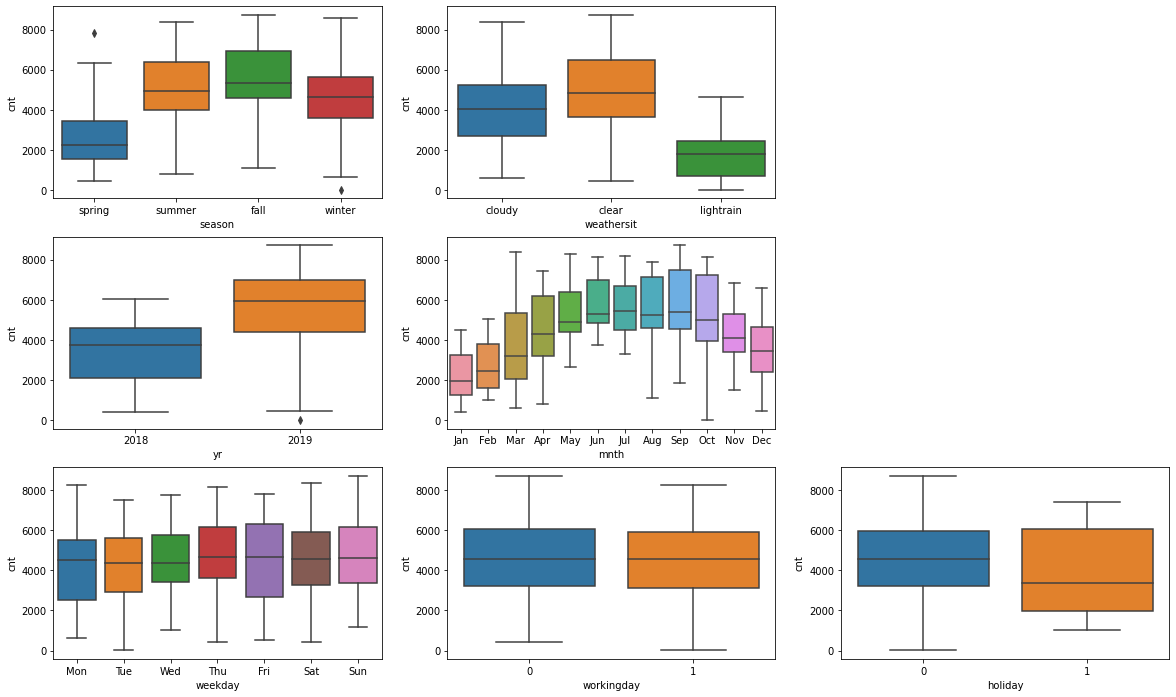

In [10]:
# Plot boxplots for categorical variables
plt.figure(figsize=(20, 12))

plt.subplot(3,3,1); sns.boxplot(x = 'season', y = 'cnt', data = df_bike)
plt.subplot(3,3,2); sns.boxplot(x = 'weathersit', y = 'cnt', data = df_bike)

plt.subplot(3,3,4); sns.boxplot(x = 'yr', y = 'cnt', data = df_bike)
plt.subplot(3,3,5); sns.boxplot(x = 'mnth', y = 'cnt', data = df_bike)

plt.subplot(3,3,7); sns.boxplot(x = 'weekday', y = 'cnt', data = df_bike)
plt.subplot(3,3,8); sns.boxplot(x = 'workingday', y = 'cnt', data = df_bike)
plt.subplot(3,3,9); sns.boxplot(x = 'holiday', y = 'cnt', data = df_bike)

### Findings
| Categorical Variable | Effect on target variable |
|---|---|
| season | The usage is more in the order fall, summer, winter and spring |
| weathersit | The usage is more in order clear, cloudy and lightrain |
| yr | The usage is more in the 2nd year (2019) than in the 1st year (2018) |
| mnth | The usage is more in the middle of the year than in the beginning or end of the year |
| weekday | The typical usge is same over all the days in a week |
| workingday | The usage is not very different on working or non-working days |
| holiday | The typical usage is more on a nonholiday than on a holiday |

<AxesSubplot:xlabel='registered', ylabel='Density'>

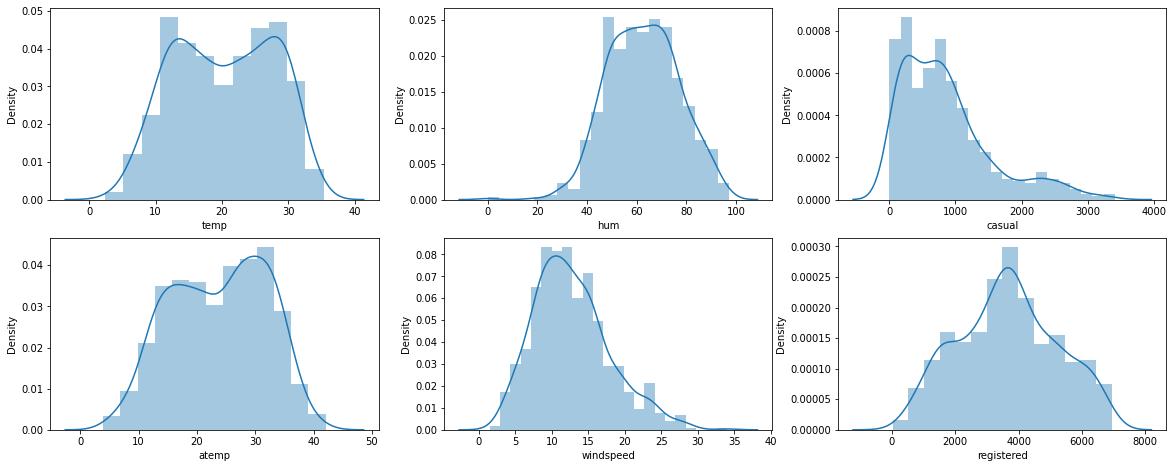

In [11]:
# Plot distplots for the numerical variables
plt.figure(figsize=(20, 12))

plt.subplot(3,3,1); sns.distplot(df_bike['temp']) 
plt.subplot(3,3,2); sns.distplot(df_bike['hum']) 
plt.subplot(3,3,3); sns.distplot(df_bike['casual']) 

plt.subplot(3,3,4); sns.distplot(df_bike['atemp']) 
plt.subplot(3,3,5); sns.distplot(df_bike['windspeed']) 
plt.subplot(3,3,6); sns.distplot(df_bike['registered']) 

### Findings
| Numerical Variable | Density |
|---|---|
| temp, atemp | The extreme temps are less in number | 
| hum | Most days the humidity is in the range 50 to 70  | 
| windspeed | Most days the windspeed is in the range 7 to 15 |
| casual | On most days there are less number of casual users |
| registered | Most days the number of registered users is aroudn 4000 | 


In [12]:
# Convert the year to numerical value
df_bike['yr'] = df_bike['yr'].apply(lambda x: int(x))

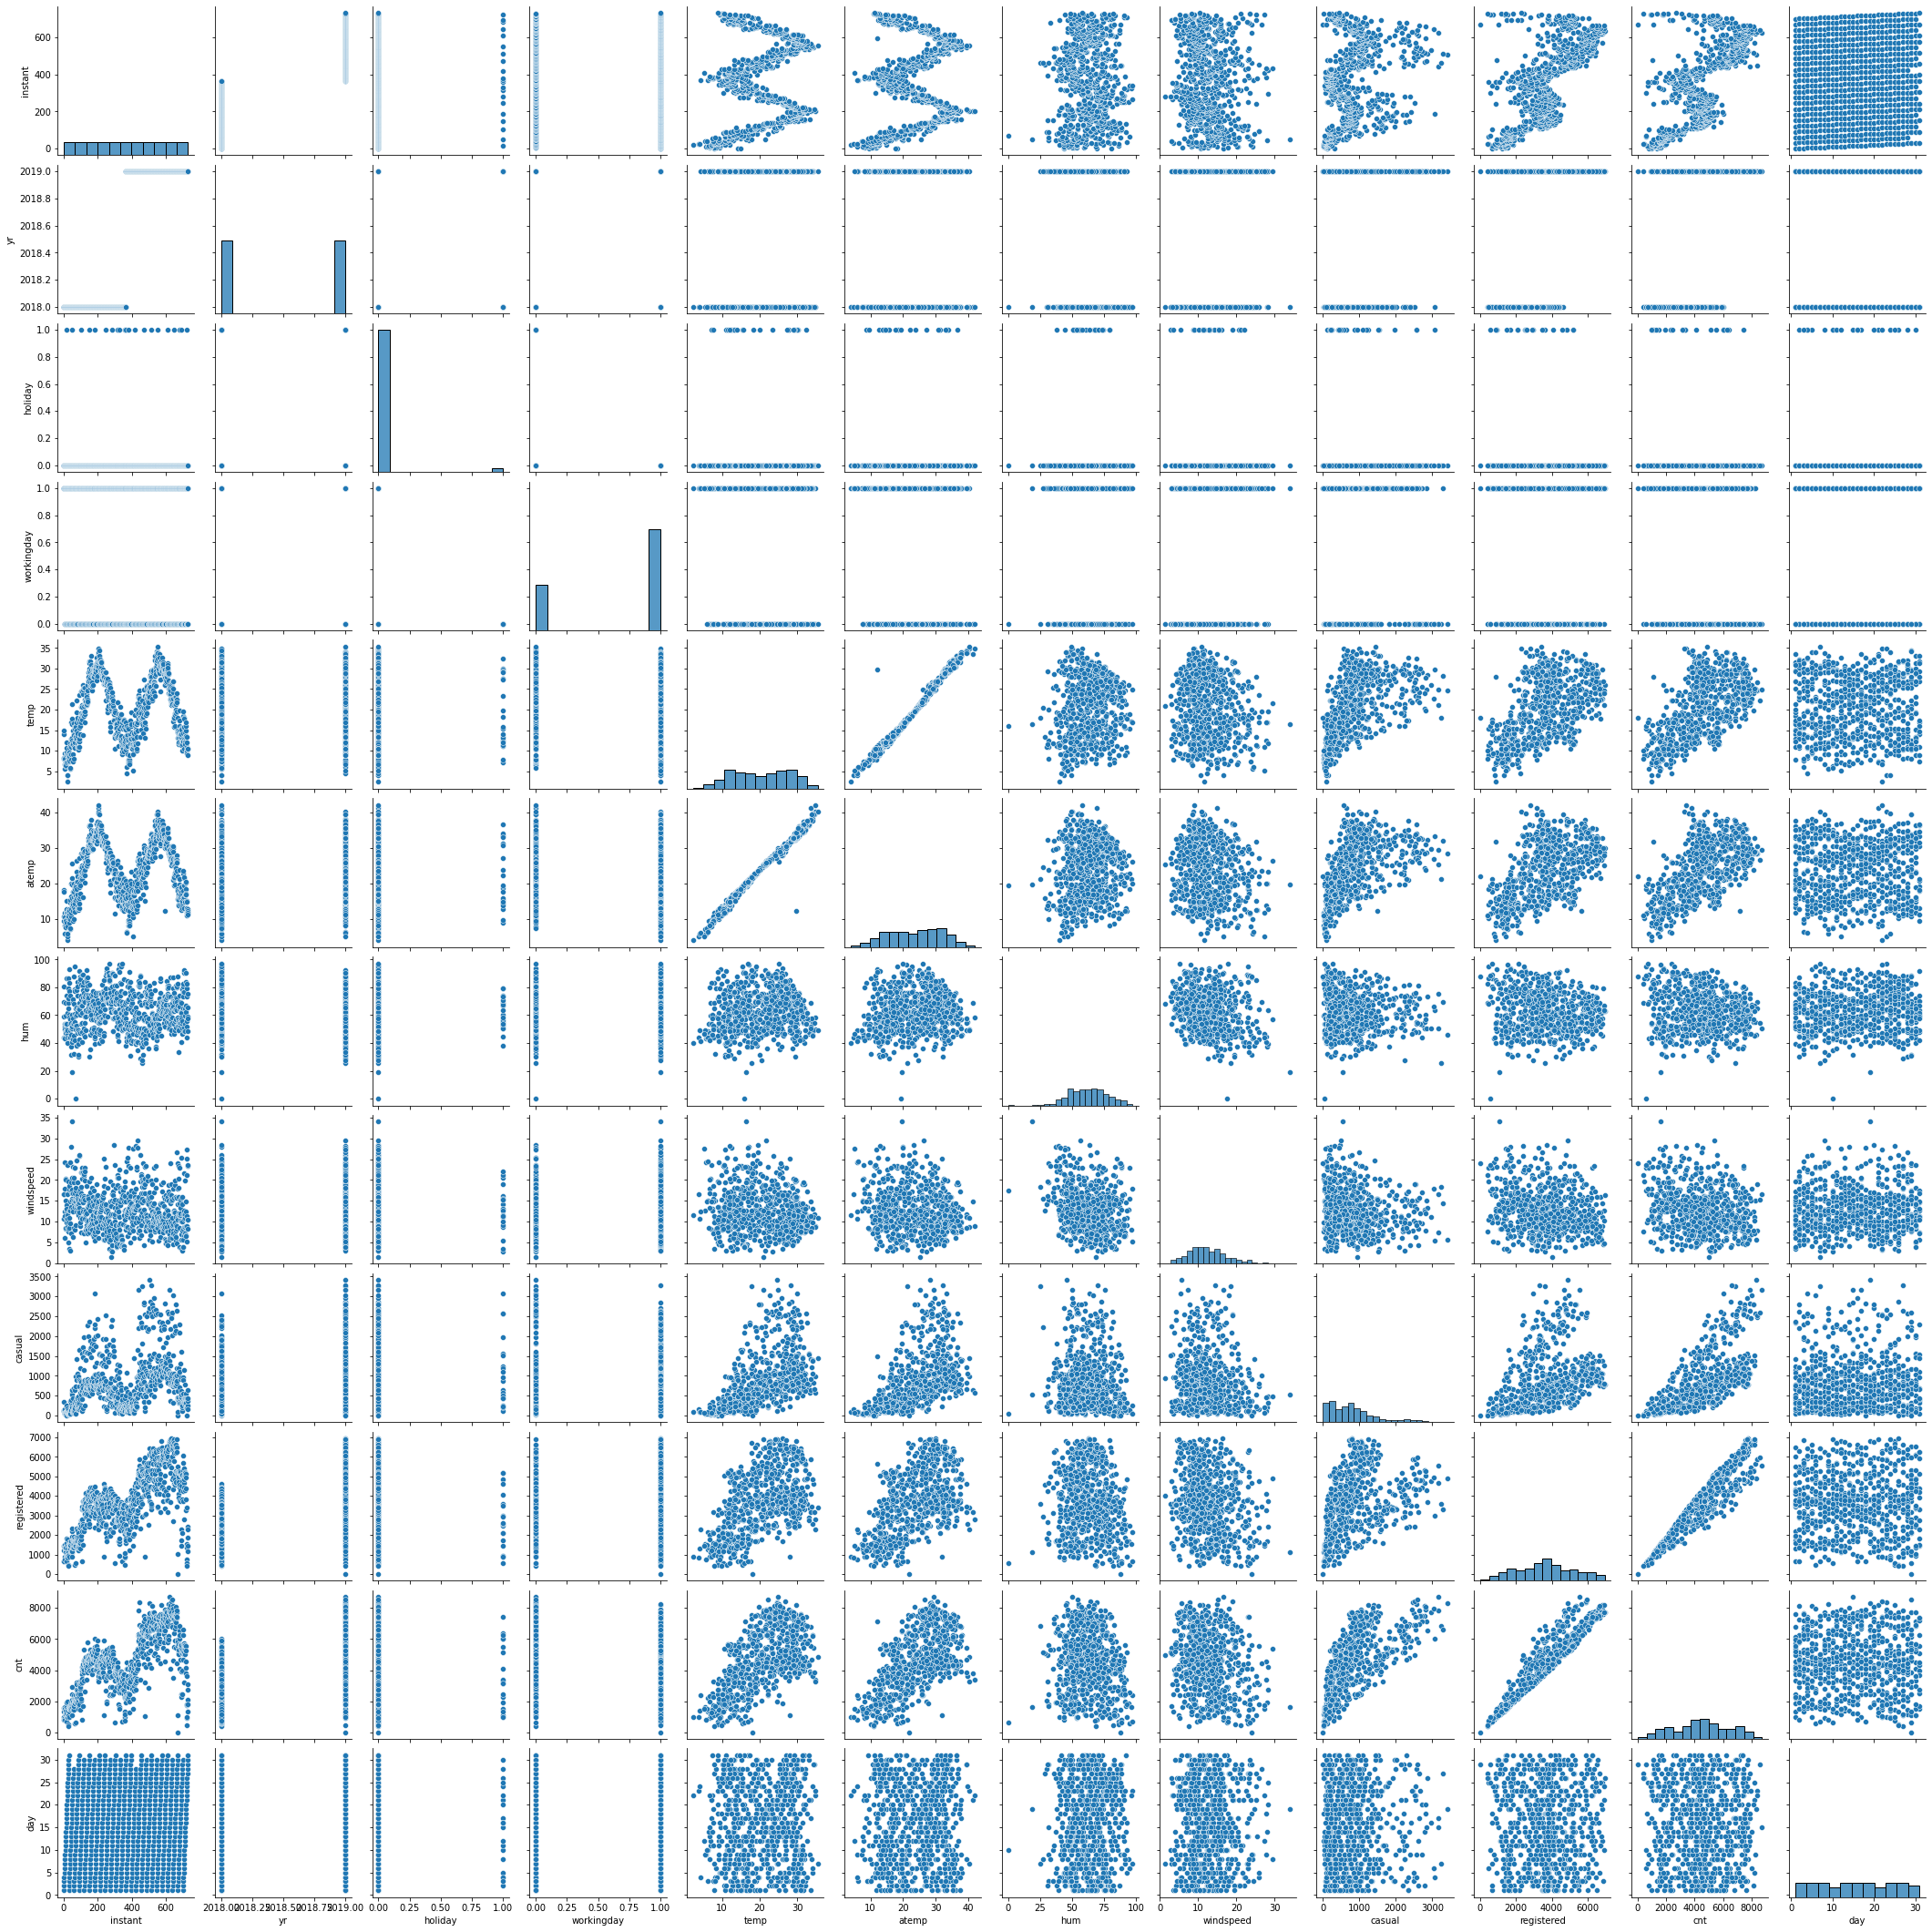

In [13]:
# Visualising pairwise correlation between numerical variables
sns.pairplot(data=df_bike.select_dtypes(include=np.number))

<AxesSubplot:>

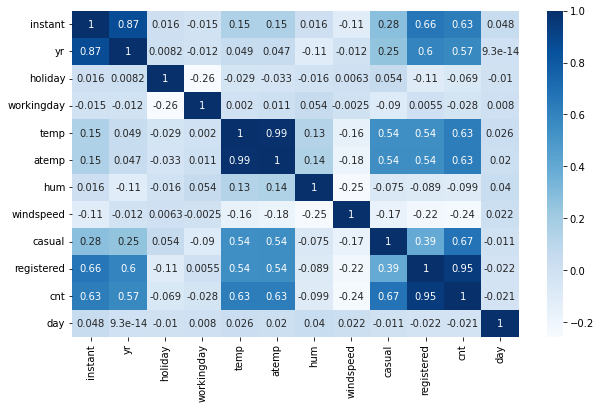

In [14]:
corr = df_bike.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="Blues", annot=True)

### Linear Relationship between independent and dependent variable (cnt)
- registered users have high correlation (0.95)
- casual users have the next highest correlation (0.67)
- instant, temp, atemp have high correlation (0.63) 

### Should we consider a linear regression model?
Since there are variables (above) that have a linear relationship with the target variable, we can consider the linear regression model

### Multi collinearity
| | |
|---|---|
| temp and atemp have very high correlation | 0.99 | Both temp and atemp represent similar information. atemp which is the perceived temperature is less explainable in business context. So remove it |
| instant & yr have high correlation | 0.87 | Between instant and year, year is more explainable. So drop instant.|

In [15]:
# Dropping one of the highly correlated pair variables
df_bike.drop(columns=['atemp','instant'],inplace=True)

In [16]:
# Since both casual and registered together add up to the cnt. We are considering the registered in the model due to high correlation with cnt. 
# So we can drop casual to avoid redundant information
#df_bike.drop(columns=['casual'],inplace=True) 

## 3. Preprocess the data
- Convert categorical variables to dummy variables
- Split the dataset to train & test datasets
- Scale the training dataset numerical variables using min-max scaling

In [17]:
print(f"BEFORE conversion:\n{df_bike.head()}")
df_bike = convertToDummies(df_bike, 'season')
df_bike = convertToDummies(df_bike, 'weathersit')
df_bike = convertToDummies(df_bike, 'mnth')
df_bike = convertToDummies(df_bike, 'weekday')
print(f"AFTER conversion:\n{df_bike.head()}")

BEFORE conversion:
   season    yr mnth  holiday weekday  workingday weathersit       temp  \
0  spring  2018  Jan        0     Mon           1     cloudy  14.110847   
1  spring  2018  Jan        0     Tue           1     cloudy  14.902598   
2  spring  2018  Jan        0     Wed           1      clear   8.050924   
3  spring  2018  Jan        0     Thu           1      clear   8.200000   
4  spring  2018  Jan        0     Fri           1      clear   9.305237   

       hum  windspeed  casual  registered   cnt  day  
0  80.5833  10.749882     331         654   985    1  
1  69.6087  16.652113     131         670   801    2  
2  43.7273  16.636703     120        1229  1349    3  
3  59.0435  10.739832     108        1454  1562    4  
4  43.6957  12.522300      82        1518  1600    5  
Before ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'day']
	After ['yr', 'mnth', 'holiday', 'weekday', 'working

In [18]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   hum         730 non-null    float64
 5   windspeed   730 non-null    float64
 6   casual      730 non-null    int64  
 7   registered  730 non-null    int64  
 8   cnt         730 non-null    int64  
 9   day         730 non-null    int64  
 10  spring      730 non-null    uint8  
 11  summer      730 non-null    uint8  
 12  winter      730 non-null    uint8  
 13  cloudy      730 non-null    uint8  
 14  lightrain   730 non-null    uint8  
 15  Aug         730 non-null    uint8  
 16  Dec         730 non-null    uint8  
 17  Feb         730 non-null    uint8  
 18  Jan         730 non-null    uint8  
 19  Jul         730 non-null    u

In [19]:
# Split the dataset into train and test
df_train, df_test = train_test_split(df_bike, train_size=0.7, random_state=100)
print(df_train.shape, df_test.shape)

(510, 32) (220, 32)


In [20]:
# Rescaling
scaler = MinMaxScaler()
num_vars = ['day', 'temp', 'hum', 'windspeed', 'registered', 'casual', 'cnt']
df_train_ = df_train.copy(True)
df_train_[num_vars] = scaler.fit_transform(df_train_[num_vars])
print(df_train_)

       yr  holiday  workingday      temp       hum  windspeed    casual  \
576  2019        0           1  0.815169  0.725633   0.264686  0.294422   
426  2019        0           0  0.442393  0.640189   0.255342  0.290765   
728  2019        0           1  0.245101  0.498067   0.663106  0.110332   
482  2019        0           0  0.395666  0.504508   0.188475  0.340750   
111  2018        0           0  0.345824  0.751824   0.380981  0.053337   
..    ...      ...         ...       ...       ...        ...       ...   
578  2019        0           1  0.863973  0.679690   0.187140  0.298994   
53   2018        0           1  0.202618  0.435939   0.111379  0.041756   
350  2018        0           1  0.248216  0.577930   0.431816  0.083206   
79   2018        0           1  0.462664  0.759870   0.529881  0.121609   
520  2019        0           1  0.600225  0.632030   0.359599  0.294422   

     registered       cnt       day  ...  May  Nov  Oct  Sep  Mon  Sat  Sun  \
576    0.899220  0.8

<AxesSubplot:>

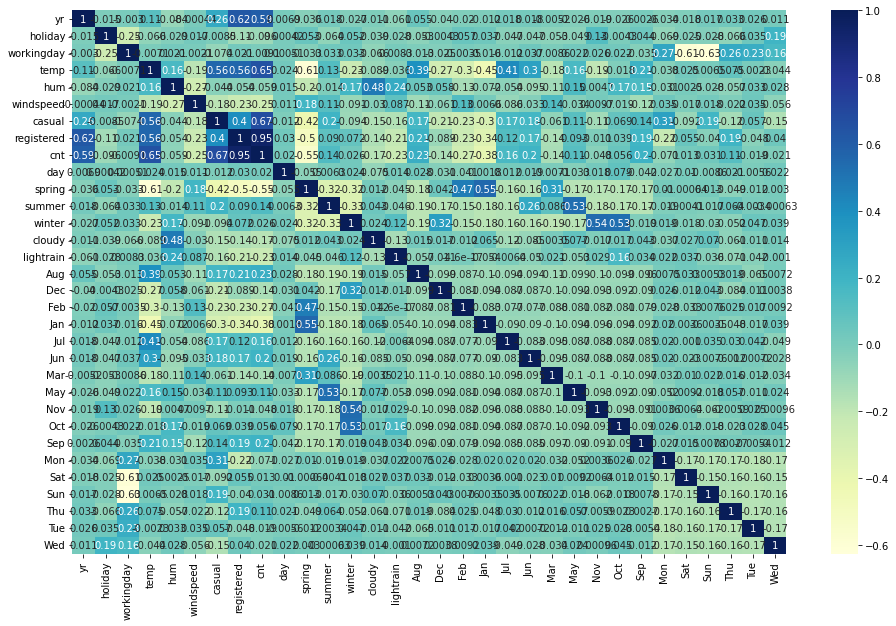

In [21]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train_.corr(),annot=True, cmap='YlGnBu')

### Model building - Strategy
- Coarse-grained feature selection: Use Recursive Feature Elimination to select 10 features
- Fine-grained feature selection: Manually eleminate eeatures to get the best model
- Recursive Feature Elimination 
- Manual Feature Elimination
- Residual Analysis
- Model Evaluation

## 4.1. Build & Evaluate Model - 1
- Recursive Feature Elimination: 10
- Manual Feature Elimination: Based on p-value (<0.05) & VIF (<10)
- Residual Analysis
- Evaluation of the model

### Recursive Feature Elemination: 10

In [22]:
X_train, y_train = getXy(df_train_)
cols = runRFE(10, X_train, y_train )

X_train = X_train[cols]
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train)

Ip - Columns: 31, ['workingday', 'Jan', 'Oct', 'casual', 'Tue', 'cloudy', 'spring', 'Dec', 'Jul', 'lightrain', 'windspeed', 'Sep', 'Aug', 'registered', 'Sat', 'Thu', 'Mar', 'Sun', 'Jun', 'Nov', 'day', 'Wed', 'yr', 'temp', 'Feb', 'May', 'holiday', 'Mon', 'winter', 'summer', 'hum']
X - Columns: 31, ['workingday', 'Jan', 'Oct', 'casual', 'Tue', 'cloudy', 'spring', 'Dec', 'Jul', 'lightrain', 'windspeed', 'Sep', 'Aug', 'registered', 'Sat', 'Thu', 'Mar', 'Sun', 'Jun', 'Nov', 'day', 'Wed', 'yr', 'temp', 'Feb', 'May', 'holiday', 'Mon', 'winter', 'summer', 'hum']
y - Columns: 1, ['cnt']
Columns selected by RFE: ['casual', 'Tue', 'Dec', 'windspeed', 'registered', 'Mar', 'Sun', 'Jun', 'temp', 'summer']
Columns dropped by RFE: ['workingday', 'Jan', 'Oct', 'cloudy', 'spring', 'Jul', 'lightrain', 'Sep', 'Aug', 'Sat', 'Thu', 'Nov', 'day', 'Wed', 'yr', 'Feb', 'May', 'holiday', 'Mon', 'winter', 'hum']
                            OLS Regression Results                            
Dep. Variable:         

### Manual Feature Elimination

In [23]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='Nov')

KeyError: "['Nov'] not found in axis"

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='windspeed')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.239e+24
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13643.
No. Observations:                 510   AIC:                        -2.727e+04
Df Residuals:                     501   BIC:                        -2.723e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.349e-13   1.38e-10     -0.001      0.9

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='Thu')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.309e+25
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13697.
No. Observations:                 510   AIC:                        -2.738e+04
Df Residuals:                     502   BIC:                        -2.734e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.908e-14   1.23e-10     -0.000      1.0

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='Mon')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.043e+24
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13358.
No. Observations:                 510   AIC:                        -2.670e+04
Df Residuals:                     503   BIC:                        -2.667e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.955e-13   2.36e-10      0.001      0.9

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='lightrain')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.549e+25
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13653.
No. Observations:                 510   AIC:                        -2.729e+04
Df Residuals:                     504   BIC:                        -2.727e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.278e-13   1.32e-10     -0.003      0.9

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='summer')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.663e+24
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13475.
No. Observations:                 510   AIC:                        -2.694e+04
Df Residuals:                     505   BIC:                        -2.692e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.955e-13   1.86e-10      0.003      0.9

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='Tue')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.807e+25
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 13673.
No. Observations:                 510   AIC:                        -2.734e+04
Df Residuals:                     506   BIC:                        -2.732e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.938e-13   1.26e-10      0.004      0.9

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,col='yr')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.359e+32
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:29   Log-Likelihood:                 17495.
No. Observations:                 510   AIC:                        -3.498e+04
Df Residuals:                     507   BIC:                        -3.497e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.281e-17   3.44e-17      2.696      0.0

In [ ]:
print(num_vars)

['day', 'temp', 'hum', 'windspeed', 'registered', 'casual', 'cnt']


### Residual Analysis

576    5.551115e-16
426    1.665335e-16
728    5.551115e-17
482    1.110223e-16
111    8.326673e-17
           ...     
578    5.551115e-16
53     1.110223e-16
350    1.665335e-16
79     8.326673e-17
520    5.551115e-16
Length: 510, dtype: float64
R-squared: 1.0
Mean of Residuals 2.51318913936785e-16


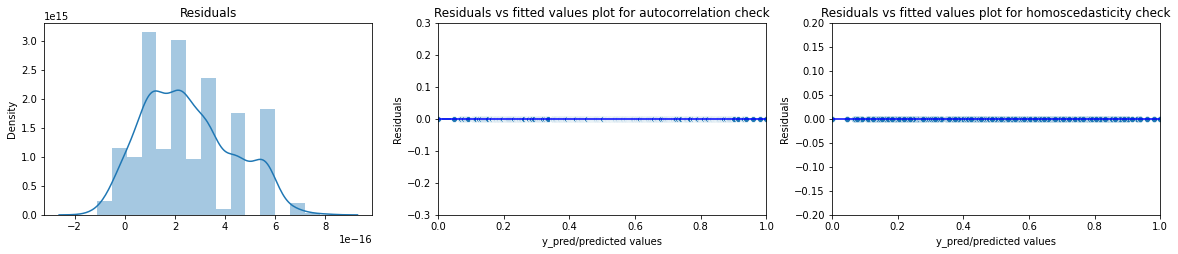

In [ ]:
res, y_train_pred = predict(lr_model, X_train_sm, y_train)
plotResidualAnalysis(res, y_train_pred)

Findings
- Error terms are not so normally distributed with mean zero.
- Autocorrelation is not very clear.
- homoscedasticity is not very clear

### Model Evaluation

In [ ]:
_, _ = evaluate(df_test, num_vars, X_train.columns.tolist(), lr_model)

Ip - Columns: 2, ['casual', 'registered']
X - Columns: 2, ['casual', 'registered']
y - Columns: 1, ['cnt']
     const    casual  registered
184    1.0  0.933557    0.427086
535    1.0  0.265163    0.767976
299    1.0  0.072539    0.346376
221    1.0  0.268820    0.559630
152    1.0  0.223712    0.608143
184    0.000000e+00
535    3.330669e-16
299    1.110223e-16
221    2.220446e-16
152    3.330669e-16
           ...     
702    5.551115e-16
127    1.110223e-16
640    6.661338e-16
72     1.110223e-16
653    5.551115e-16
Length: 220, dtype: float64
R-squared: 1.0


### Summary of Model -1
Model = 0.3775 * casual + 0.7968 * registered + 9.281e-17
- R-squared of the training dataset is high 1 
- All the following assumptions of the linear regression model have been validated. So the model is a good and can be considered.
    - There is a linear relationship between X and Y
    - Error terms are normally distributed with mean zero(not X, Y):
    - Error terms are independent of each other:
    - Error terms have constant variance (homoscedasticity)
- R-squared of the test dataset of is high 1

But the model has only trivial features - casual & registered - sum of which is the target variable - cnt. So discarding this model.

## 4.2. Build & Evaluate Model - 2
- Drop 'casual' as both 'registered' and 'casual' have redundant information.
- Recursive Feature Elimination: 10
- Manual Feature Elimination: Based on p-value (<0.05) & VIF (<10)
- Residual Analysis
- Evaluation of the model

In [ ]:
# Dropping 'casual' as both 'registered' and 'casual' have redundant information. 
df_train.drop(columns='casual', inplace=True)

In [ ]:
# Scale the variables
df_train_ = df_train.copy(True)

scaler = MinMaxScaler()
num_vars = ['day', 'temp', 'hum', 'windspeed', 'registered', 'cnt']
df_train_[num_vars] = scaler.fit_transform(df_train_[num_vars])
print(df_train_)

       yr  holiday  workingday      temp       hum  windspeed  registered  \
576  2019        0           1  0.815169  0.725633   0.264686    0.899220   
426  2019        0           0  0.442393  0.640189   0.255342    0.446145   
728  2019        0           1  0.245101  0.498067   0.663106    0.203869   
482  2019        0           0  0.395666  0.504508   0.188475    0.444701   
111  2018        0           0  0.345824  0.751824   0.380981    0.214554   
..    ...      ...         ...       ...       ...        ...         ...   
578  2019        0           1  0.863973  0.679690   0.187140    0.903552   
53   2018        0           1  0.202618  0.435939   0.111379    0.253826   
350  2018        0           1  0.248216  0.577930   0.431816    0.352873   
79   2018        0           1  0.462664  0.759870   0.529881    0.239099   
520  2019        0           1  0.600225  0.632030   0.359599    0.868178   

          cnt       day  spring  ...  May  Nov  Oct  Sep  Mon  Sat  Sun  Th

### Recursive Feature Elimination: 10

In [ ]:
X_train, y_train = getXy(df_train_)
cols = runRFE(10, X_train, y_train )

X_train = X_train[cols]
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train)

Ip - Columns: 30, ['Jan', 'registered', 'lightrain', 'Dec', 'Nov', 'May', 'workingday', 'Mar', 'temp', 'Sun', 'holiday', 'Thu', 'Mon', 'hum', 'Tue', 'Sat', 'day', 'winter', 'summer', 'cloudy', 'Wed', 'Oct', 'Feb', 'yr', 'Aug', 'Sep', 'Jul', 'windspeed', 'spring', 'Jun']
X - Columns: 30, ['Jan', 'registered', 'lightrain', 'Dec', 'Nov', 'May', 'workingday', 'Mar', 'temp', 'Sun', 'holiday', 'Thu', 'Mon', 'hum', 'Tue', 'Sat', 'day', 'winter', 'summer', 'cloudy', 'Wed', 'Oct', 'Feb', 'yr', 'Aug', 'Sep', 'Jul', 'windspeed', 'spring', 'Jun']
y - Columns: 1, ['cnt']
Columns selected by RFE: ['registered', 'workingday', 'temp', 'Mon', 'hum', 'Tue', 'Sat', 'summer', 'Oct', 'windspeed']
Columns dropped by RFE: ['Jan', 'Dec', 'Mar', 'holiday', 'day', 'Oct', 'Feb', 'spring', 'May', 'workingday', 'temp', 'Sun', 'hum', 'Sat', 'cloudy', 'Wed', 'Aug', 'Sep', 'Jul', 'Jun', 'winter', 'Nov', 'windspeed', 'Thu', 'Mon', 'lightrain', 'summer', 'Tue', 'yr', 'Jan', 'Dec', 'Mar', 'holiday', 'Thu', 'day', 'Feb',

- All variables are significant (low p-values). So nothing to drop here.
- temp, hum,registered, workingday have VIF above 5 but is below 10. This is not too high. 
    - Registered & temp have high correlation with the target variable. So not dropping these variables. 
    - workingday VIF is just a little high than 5. And it is an explainable feature. So not dropping it.
    - hum has no low correlation with the target variable. Slightly difficult to explain in the model. So **dropping hum**.

### Manual Feature Elimination

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, "hum")

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1125.
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:30   Log-Likelihood:                 818.29
No. Observations:                 510   AIC:                            -1617.
Df Residuals:                     500   BIC:                            -1574.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0140      0.010      1.445      0.1

### Residual Analysis

576   -0.013990
426    0.004094
728   -0.031343
482   -0.004126
111   -0.074760
         ...   
578   -0.022296
53     0.028795
350   -0.066815
79     0.013932
520   -0.009468
Length: 510, dtype: float64
R-squared: 0.95
Mean of Residuals 2.6758551801357694e-15
['day', 'temp', 'hum', 'windspeed', 'registered', 'cnt']


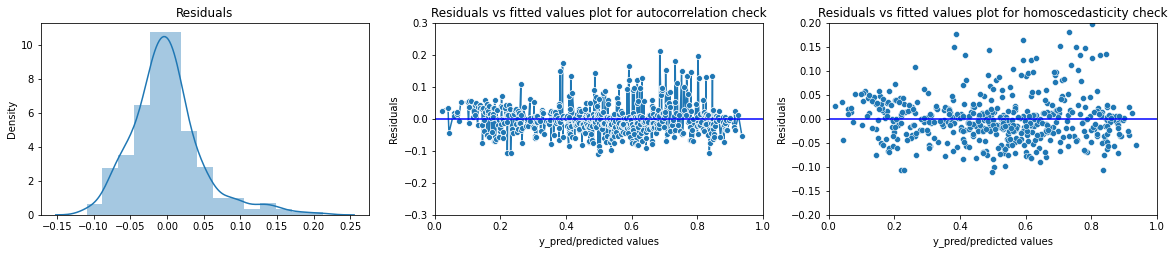

In [ ]:
res, y_train_pred = predict(lr_model, X_train_sm, y_train)
plotResidualAnalysis(res, y_train_pred)
print(num_vars)

Findings
- Error terms are normally distributed with mean zero.
- Error terms are independent of each other - no pattern observed.
- Error terms have constant variance (homoscedasticity)

### Model Evaluation

In [ ]:
_, _ = evaluate(df_test, num_vars, X_train.columns.tolist(), lr_model)

Ip - Columns: 9, ['registered', 'workingday', 'temp', 'Mon', 'Tue', 'Sat', 'summer', 'Oct', 'windspeed']
X - Columns: 9, ['registered', 'workingday', 'temp', 'Mon', 'Tue', 'Sat', 'summer', 'Oct', 'windspeed']
y - Columns: 1, ['cnt']
     const  registered  workingday      temp  Mon  Tue  Sat  summer  Oct  \
184    1.0    0.427086           0  0.831783    0    0    0       0    0   
535    1.0    0.767976           1  0.901354    0    0    0       1    0   
299    1.0    0.346376           0  0.511964    0    0    1       0    1   
221    1.0    0.559630           1  0.881625    0    0    0       0    0   
152    1.0    0.608143           0  0.817246    0    0    1       1    0   

     windspeed  
184   0.084219  
535   0.153728  
299   0.334206  
221   0.339570  
152   0.537414  
184    0.190999
535   -0.058071
299   -0.036063
221    0.005245
152   -0.044759
         ...   
702   -0.020022
127    0.026805
640   -0.072416
72     0.042615
653   -0.005684
Length: 220, dtype: float64
R-sq

### Summary of Model - 2
Model = 0.8980 * registered - 0.0743 * workingday + 0.1295 * temp + 0.1088 * Mon + 0.0486 * Tue - 0.0600 * Sat + 0.0305 * summer + 0.0222 * Oct -0.0422 * windspeed +  0.0140  
- R-squared & Adj. R-squared of the training dataset is high 0.953 & .952 respectively  
- All the following assumptions of the linear regression model have been validated. So the model is a good and can be considered.
    - There is a linear relationship between X and Y
    - Error terms are normally distributed with mean zero(not X, Y):
    - Error terms are independent of each other:
    - Error terms have constant variance (homoscedasticity)
- R-squared of the test dataset of is high .94

The model has only decent features that can be interpreted and be used in business context.

## 4.3. Build & Evaluate Model - 3
- Drop 'casual' as both 'registered' and 'casual' have redundant information.
- Recursive Feature Elimination: 10
- Manual Feature Elimination: Based on p-value (<0.05) & VIF (<10)
- Residual Analysis
- Evaluation of the model

### Recursive Feature Elimination: 15
Let's try and improve the previous model. Let's choose few more features

In [ ]:
X_train, y_train = getXy(df_train_)
cols = runRFE(15, X_train, y_train )

X_train = X_train[cols]
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train)

Ip - Columns: 30, ['Jan', 'registered', 'lightrain', 'Dec', 'Nov', 'May', 'workingday', 'Mar', 'temp', 'Sun', 'holiday', 'Thu', 'Mon', 'hum', 'Tue', 'Sat', 'day', 'winter', 'summer', 'cloudy', 'Wed', 'Oct', 'Feb', 'yr', 'Aug', 'Sep', 'Jul', 'windspeed', 'spring', 'Jun']
X - Columns: 30, ['Jan', 'registered', 'lightrain', 'Dec', 'Nov', 'May', 'workingday', 'Mar', 'temp', 'Sun', 'holiday', 'Thu', 'Mon', 'hum', 'Tue', 'Sat', 'day', 'winter', 'summer', 'cloudy', 'Wed', 'Oct', 'Feb', 'yr', 'Aug', 'Sep', 'Jul', 'windspeed', 'spring', 'Jun']
y - Columns: 1, ['cnt']
Columns selected by RFE: ['Jan', 'registered', 'lightrain', 'Dec', 'workingday', 'temp', 'Sun', 'Mon', 'hum', 'Tue', 'Sat', 'summer', 'Oct', 'Feb', 'windspeed']
Columns dropped by RFE: ['Jan', 'Dec', 'Mar', 'holiday', 'day', 'Oct', 'Feb', 'spring', 'May', 'workingday', 'temp', 'Sun', 'hum', 'Sat', 'cloudy', 'Wed', 'Aug', 'Sep', 'Jul', 'Jun', 'winter', 'Nov', 'windspeed', 'Thu', 'Mon', 'lightrain', 'summer', 'Tue', 'yr', 'Jan', 'Dec

### Manual Feature Elimination

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,'Sun')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     762.5
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          4.94e-324
Time:                        18:56:30   Log-Likelihood:                 833.59
No. Observations:                 510   AIC:                            -1637.
Df Residuals:                     495   BIC:                            -1574.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0787      0.017      4.655      0.0

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, 'Feb')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     817.2
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:30   Log-Likelihood:                 831.91
No. Observations:                 510   AIC:                            -1636.
Df Residuals:                     496   BIC:                            -1577.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0681      0.016      4.285      0.0

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train,'Jan')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     883.8
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:30   Log-Likelihood:                 831.01
No. Observations:                 510   AIC:                            -1636.
Df Residuals:                     497   BIC:                            -1581.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0612      0.015      4.072      0.0

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, 'lightrain')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     960.0
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:30   Log-Likelihood:                 829.47
No. Observations:                 510   AIC:                            -1635.
Df Residuals:                     498   BIC:                            -1584.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0646      0.015      4.322      0.0

In [ ]:
lr_model, X_train_sm = dropColumnAndBuildModel(X_train, y_train, 'hum')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1026.
Date:                Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:56:30   Log-Likelihood:                 822.05
No. Observations:                 510   AIC:                            -1622.
Df Residuals:                     499   BIC:                            -1576.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.010      2.159      0.0

### Residual Analysis

576   -0.015102
426   -0.000031
728   -0.012612
482   -0.006672
111   -0.076436
         ...   
578   -0.023217
53     0.023509
350   -0.049260
79     0.014671
520   -0.009954
Length: 510, dtype: float64
R-squared: 0.95
Mean of Residuals 1.891515266856468e-15
['day', 'temp', 'hum', 'windspeed', 'registered', 'cnt']


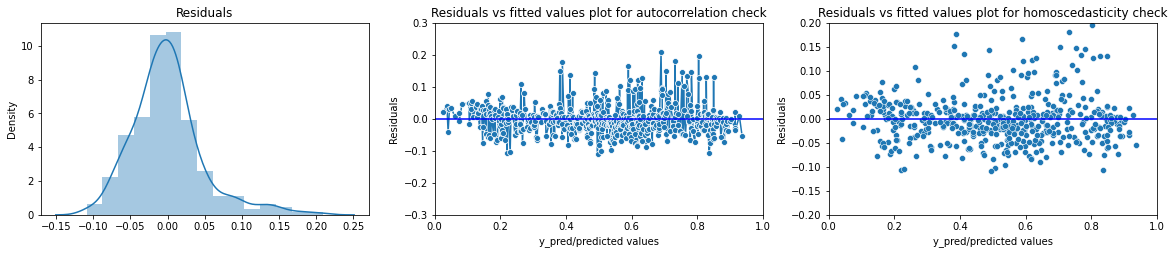

In [ ]:
res, y_train_pred = predict(lr_model, X_train_sm, y_train)
plotResidualAnalysis(res, y_train_pred)
print(num_vars)

Findings
- Error terms are normally distributed with mean zero.
- Error terms are independent of each other - no pattern observed.
- Error terms have constant variance (homoscedasticity)

### Model Evaluation

In [ ]:
_, _ = evaluate(df_test, num_vars, X_train.columns.tolist(), lr_model)

Ip - Columns: 10, ['registered', 'Dec', 'workingday', 'temp', 'Mon', 'Tue', 'Sat', 'summer', 'Oct', 'windspeed']
X - Columns: 10, ['registered', 'Dec', 'workingday', 'temp', 'Mon', 'Tue', 'Sat', 'summer', 'Oct', 'windspeed']
y - Columns: 1, ['cnt']
     const  registered  Dec  workingday      temp  Mon  Tue  Sat  summer  Oct  \
184    1.0    0.427086    0           0  0.831783    0    0    0       0    0   
535    1.0    0.767976    0           1  0.901354    0    0    0       1    0   
299    1.0    0.346376    0           0  0.511964    0    0    1       0    1   
221    1.0    0.559630    0           1  0.881625    0    0    0       0    0   
152    1.0    0.608143    0           0  0.817246    0    0    1       1    0   

     windspeed  
184   0.084219  
535   0.153728  
299   0.334206  
221   0.339570  
152   0.537414  
184    0.190002
535   -0.056107
299   -0.035214
221    0.006047
152   -0.042000
         ...   
702   -0.001056
127    0.026312
640   -0.072138
72     0.038863
65

### Summary of Model - 3
Model = 0.9011 * registered - 0.0752 * workingday + 0.1202 * temp + 0.1098 * Mon + 0.0489 * Tue - 0.0607 * Sat + 0.0282 * summer + 0.0192 * Oct - 0.0227 * Dec - 0.0454 * windspeed +  0.0217
- R-squared & Adj. R-squared of the training dataset is high 0.953 & .952 respectively  
- All the following assumptions of the linear regression model have been validated. So the model is a good and can be considered.
    - There is a linear relationship between X and Y
    - Error terms are normally distributed with mean zero(not X, Y):
    - Error terms are independent of each other:
    - Error terms have constant variance (homoscedasticity)
- R-squared of the test dataset of is high .95

The model has overlapping features with the model 2 and 1 additional feature "Dec" which is not too useful. So discarding this model.

## 6. Interpret the Model

Among the 3 models we built, the second model is the best as it has optimal number of interpretable features and good R-squared values (0.95). So we will go with the model2.

<font size="4"> 
cnt = 0.8980 * registered +  0.1296 * temp - 0.0422 * windspeed + 0.1088 * Mon + 0.0486 * Tue - 0.0600 * Sat - 0.0743 * workingday + 0.0222 * Oct + 0.0305 * summer +  0.0140
</font>  

### How are the features explaining the demand of the shared bikes?
- The top 3 significant features that impact the demand
    - The number Registered users result in higher demand.
    - Higher temperature results in higher demand.
    - On Mondays there is higher demand.

- Others
    - On Saturdays, there is slightly lower demand
    - On working days, there is slightly lower demand
    - On Tuesdays, there is slightly higher demand
    - In summer and October, the demand is slightly higher
    - Higher the Windspeed, lesser the demand 

Steps that can be taken to improve demand
- -> Convert casual users to registered users by offering some incentives.
- -> Make more cycles available during Mon, Tue and holidays. Plan maintenance activities on the other days (maybe Saturday)
- -> Give some discounts/offers to increase the demand on the other days